# Executing a Simple Quantum Circuit with Qiskit
Qiskit abstracts many aspects of the quantum compilation process, allowing us to interface with complex systems with a bit of simple python. To use Qiskit, a user would typically:
1. Create a quantum circuit
2. Transpile the circuit onto a backend of choice (either a simulated backend or real quantum hardware)
3. Execute the circuit on the chosen backend
4. Get the results of the executed quantum circuit.

It all starts with first installing the Qiskit package:

In [51]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [52]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

# 1) Lets create a simple quantum circuit.
qc = QuantumCircuit(5)
qc.h(0)
qc.cx(0,range(1,5))
qc.measure_all()
qc.draw()

┌───┐                     ░ ┌─┐            
   q_0: ┤ H ├──■────■────■────■───░─┤M├────────────
        └───┘┌─┴─┐  │    │    │   ░ └╥┘┌─┐         
   q_1: ─────┤ X ├──┼────┼────┼───░──╫─┤M├─────────
             └───┘┌─┴─┐  │    │   ░  ║ └╥┘┌─┐      
   q_2: ──────────┤ X ├──┼────┼───░──╫──╫─┤M├──────
                  └───┘┌─┴─┐  │   ░  ║  ║ └╥┘┌─┐   
   q_3: ───────────────┤ X ├──┼───░──╫──╫──╫─┤M├───
                       └───┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                            └───┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════════════════════════╩══╩══╩══╩══╩═
                                     0  1  2  3  4

In [53]:
from qiskit.test.mock import FakeBoeblingen
from qiskit.compiler import transpile

# 2) Lets transpile the circuit on a simulated noisy quantum hardware backend (more on this step later).
simulated_backend = FakeBoeblingen()
transpiled_qc = transpile(qc, simulated_backend, optimization_level=0)

In [54]:
# 3) Lets execute the transpiled circuit on the simulated noisy backend
results = simulated_backend.run(transpiled_qc).result()

# Note: For more information about simulated noisy backends, please visit:
# https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html

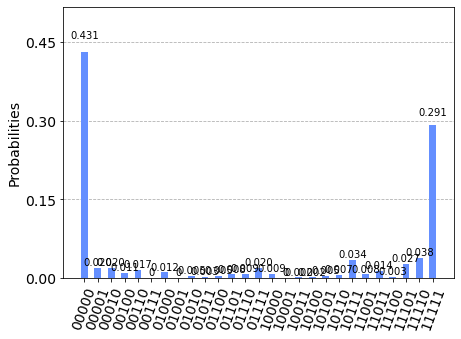

In [55]:
from qiskit.tools.visualization import plot_histogram

# 4) Lets get the results of the executed circuit
counts = results.get_counts()
plot_histogram(counts)

Here we simply created a circuit, transpiled the circuit, executed the circuit on a backend, and printed the results. A key step in that process was step 2, the transpilation. In the rest of this tutorial we will focus on the transpilation process and what goes on behind the scenes in this step. 

# Transpilation Process

The goal of the transpilation process is to injest a quantum circuit and spit out an optimized quantum circuit after having performed several transformative passes.

![Transpilation Passes](transpiling_core_steps.png)


Note: See [here](https://qiskit.org/documentation/apidoc/transpiler.html) For more information about the transpilation process.

###  Back to our example
This is exactly what we did in step 2 earlier,
```{python}
simulated_backend = FakeBoeblingen()
transpiled_qc = transpile(qc, simulated_backend, optimization_level=0)
```
The transpile function uses the ``backend`` parameter to optimize the quantum circuit according to the particular hardware the quantum circuit will be running on, therefore, the transpilation process is **"hardware aware"**.

### What other parameters does the `transpile()` function use?
The `transpile()` function has another parameter called `optimization_level`, which specifies a predefined transpilation process. As shown earlier, the transpilation process involves gate optimization, device connectivity optimization, and more - in fact, it's a somewhat daunting list. Again, Qiskit abstracts these concepts away and allows a quantum programmer to use one of four predefined transpilation processes without fiddling with the details. By default `optimization_level = 1`, but we can set it to four different values as shown here:
```{python}
simulated_backend = FakeBoeblingen()
transpiled_qc0 = transpile(qc, simulated_backend, optimization_level=0)  # No Optimization
transpiled_qc1 = transpile(qc, simulated_backend, optimization_level=1)  # Some Optimization
transpiled_qc2 = transpile(qc, simulated_backend, optimization_level=2)  # More Optimization
transpiled_qc3 = transpile(qc, simulated_backend, optimization_level=3)  # Maximum Optimization
```

Note: See [here](https://qiskit.org/documentation/stubs/qiskit.compiler.transpile.html) For more information about the traspiler parameters.

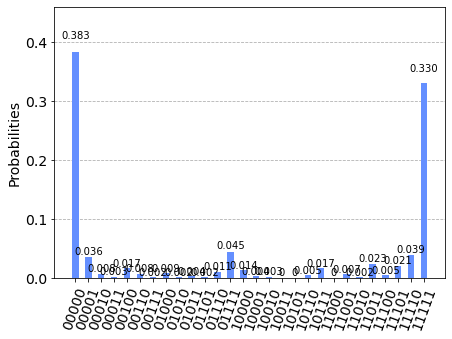

In [56]:
# 2) Lets transpile our previous circuit again using the most advanced predefined transpilation process, optimization_level=3
transpiled_qc3 = transpile(qc, simulated_backend, optimization_level=3)

# 3) Lets execute the transpiled circuit on the simulated noisy backend
results = simulated_backend.run(transpiled_qc3).result()

# 4) Lets get the results of the executed circuit
counts = results.get_counts()
plot_histogram(counts)

As you can see, in general you will find that the transpiled circuit using optimization_level=3 produces more accurate probabilities than a transpiled circuit using optimization_level=0.

# Example 1: Bernstein-Vazirani Circuit for 3 bit hidden string s
Here we will go over a small circuit that implements the BV algorithm for a 3 bit hidden string s.

In [57]:
### Lets defined a new circuit of your choice with no measurements

s = '011'   # the hidden binary string
n = 3 # number of bits used to represent s


# We need a circuit with n qubits, plus one auxiliary qubit
# We also need n classical bits to write the output to
qc = QuantumCircuit(n+1, n)

# Put auxiliary in the minus state |->
# We leave the other n qubits in just |0>
qc.h(n)
qc.z(n)

# Apply Hadamard gates to each of the n "main" qubits (excluding the auxiliary)
# before querying the oracle
for i in range(n):
    qc.h(i)
    
# Apply barrier
qc.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        qc.i(q)
    else:
        qc.cx(q, n)
        
# Apply barrier
qc.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    qc.h(i)


# Measurement
for i in range(n):
    qc.measure(i, i)


qc.draw()

┌───┐      ░                 ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░───■─────────────░─┤ H ├┤M├──────
     ├───┤      ░   │             ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░───┼─────────■───░─┤ H ├─╫─┤M├───
     ├───┤      ░   │  ┌───┐  │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼──┤ I ├──┼───░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐└───┘┌─┴─┐ ░ └───┘ ║  ║ └╥┘
q_3: ┤ H ├┤ Z ├─░─┤ X ├─────┤ X ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └───┘     └───┘ ░       ║  ║  ║ 
c: 3/═════════════════════════════════════╩══╩══╩═
                                          0  1  2

### Choose of Backend
Here we will be using the `FakeBoeblingen()` backend and print out its basic information.
For more information of the backend please visit:
1) [Backend_Resource1](https://qiskit.org/documentation/stubs/qiskit.providers.models.BackendConfiguration.html#qiskit.providers.models.BackendConfiguration)

2) [Backend_Resource2](https://qiskit.org/documentation/tutorials/circuits_advanced/08_gathering_system_information.html)

In [58]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()


# Print out basic features of this backend. Note, I am using a function found in Backend_Resource2
config = simulated_backend.configuration()
print("This backend is called {0}, and is on version {1}. \nIt has {2} qubit{3}. \nIt "
      "{4} OpenPulse programs. \nThe basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

This backend is called fake_boeblingen, and is on version 1.2.9. 
It has 20 qubits. 
It supports OpenPulse programs. 
The basis gates supported on this device are ['id', 'u1', 'u2', 'u3', 'cx'].


### Optimization_level=0
This option does no optimization, so you end up using your input circuit on your hardware exactly as its been defined. This will give bad results, because your circuit does not even consider the device connectivity, there is no reduction of swap gates, etc.

In [59]:
transpiled_qc0 = transpile(qc, simulated_backend, optimization_level=0)  # No Optimization
print('Optimization Level 0')
print('Depth:', transpiled_qc0.depth())
print('Gate counts:', transpiled_qc0.count_ops())
transpiled_qc0.draw()

Optimization Level 0
Depth: 12
Gate counts: OrderedDict([('cx', 11), ('u2', 7), ('barrier', 3), ('measure', 3), ('u1', 1), ('id', 1)])


┌─────────┐          ░      ┌───┐                         »
        q_0 -> 0 ┤ U2(0,π) ├──────────░───■──┤ X ├──■──────────────────────»
                 ├─────────┤          ░ ┌─┴─┐└─┬─┘┌─┴─┐          ┌───┐     »
        q_1 -> 1 ┤ U2(0,π) ├──────────░─┤ X ├──■──┤ X ├──■────■──┤ X ├──■──»
                 ├─────────┤          ░ └───┘┌───┐└───┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐»
        q_2 -> 2 ┤ U2(0,π) ├──────────░───■──┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├»
                 ├─────────┤┌───────┐ ░ ┌─┴─┐└─┬─┘┌─┴─┐├───┤└───┘     └───┘»
        q_3 -> 3 ┤ U2(0,π) ├┤ U1(π) ├─░─┤ X ├──■──┤ X ├┤ I ├───────────────»
                 └─────────┘└───────┘ ░ └───┘     └───┘└───┘               »
  ancilla_0 -> 4 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_1 -> 5 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_2 -> 6 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_3 -> 7 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_4 -> 8 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_5 -> 9 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_6 -> 10 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_7 -> 11 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_8 -> 12 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_9 -> 13 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_10 -> 14 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_11 -> 15 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_12 -> 16 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_13 -> 17 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_14 -> 18 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_15 -> 19 ──────────────────────────────────────────────────────────»
                                                                           »
            c: 3/══════════════════════════════════════════════════════════»
                                                                           »
«                       ░ ┌─────────┐ ░    ┌─┐   
«        q_0 -> 0 ──■───░─┤ U2(0,π) ├─░────┤M├───
«                 ┌─┴─┐ ░ └─────────┘ ░    └╥┘   
«        q_1 -> 1 ┤ X ├─░─────────────░─────╫────
«                 └───┘ ░ ┌─────────┐ ░ ┌─┐ ║    
«        q_2 -> 2 ──────░─┤ U2(0,π) ├─░─┤M├─╫────
«                       ░ ├─────────┤ ░ └╥┘ ║ ┌─┐
«        q_3 -> 3 ──────░─┤ U2(0,π) ├─░──╫──╫─┤M├
«                       ░ └─────────┘ ░  ║  ║ └╥┘
«  ancilla_0 -> 4 ────────────────────░──╫──╫──╫─
«                                     ░  ║  ║  ║ 
«  ancilla_1 -> 5 ────────────────────░──╫──╫──╫─
«                                     ░  ║  ║  ║ 
«  ancilla_2 -> 6 ────────────────────░──╫──╫──╫─
«     

The above circuit is hard to read, therefore we will convert it to a **Directed Acyclic Graph (DAG)** to visualize it more easily. We must first install some packages to conver the circuit to a DAG, and then use the `pip install pydot` command which allows us to visually see the DAG.

In [60]:
results_BV_Lev0 = simulated_backend.run(transpiled_qc0).result()

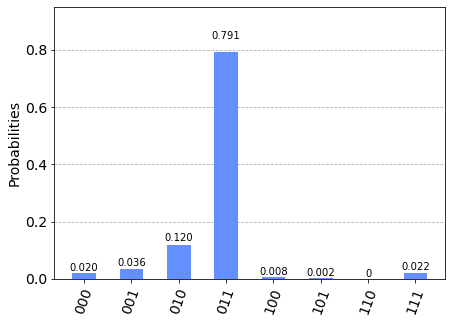

In [61]:
counts = results_BV_Lev0.get_counts()
plot_histogram(counts)
# optimization_level=0: just maps the circuit to the backend, with no explicit optimization 
# (except whatever optimizations the mapper does).

In [62]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer

# Required software to visually see DAG
!pip install pydot

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


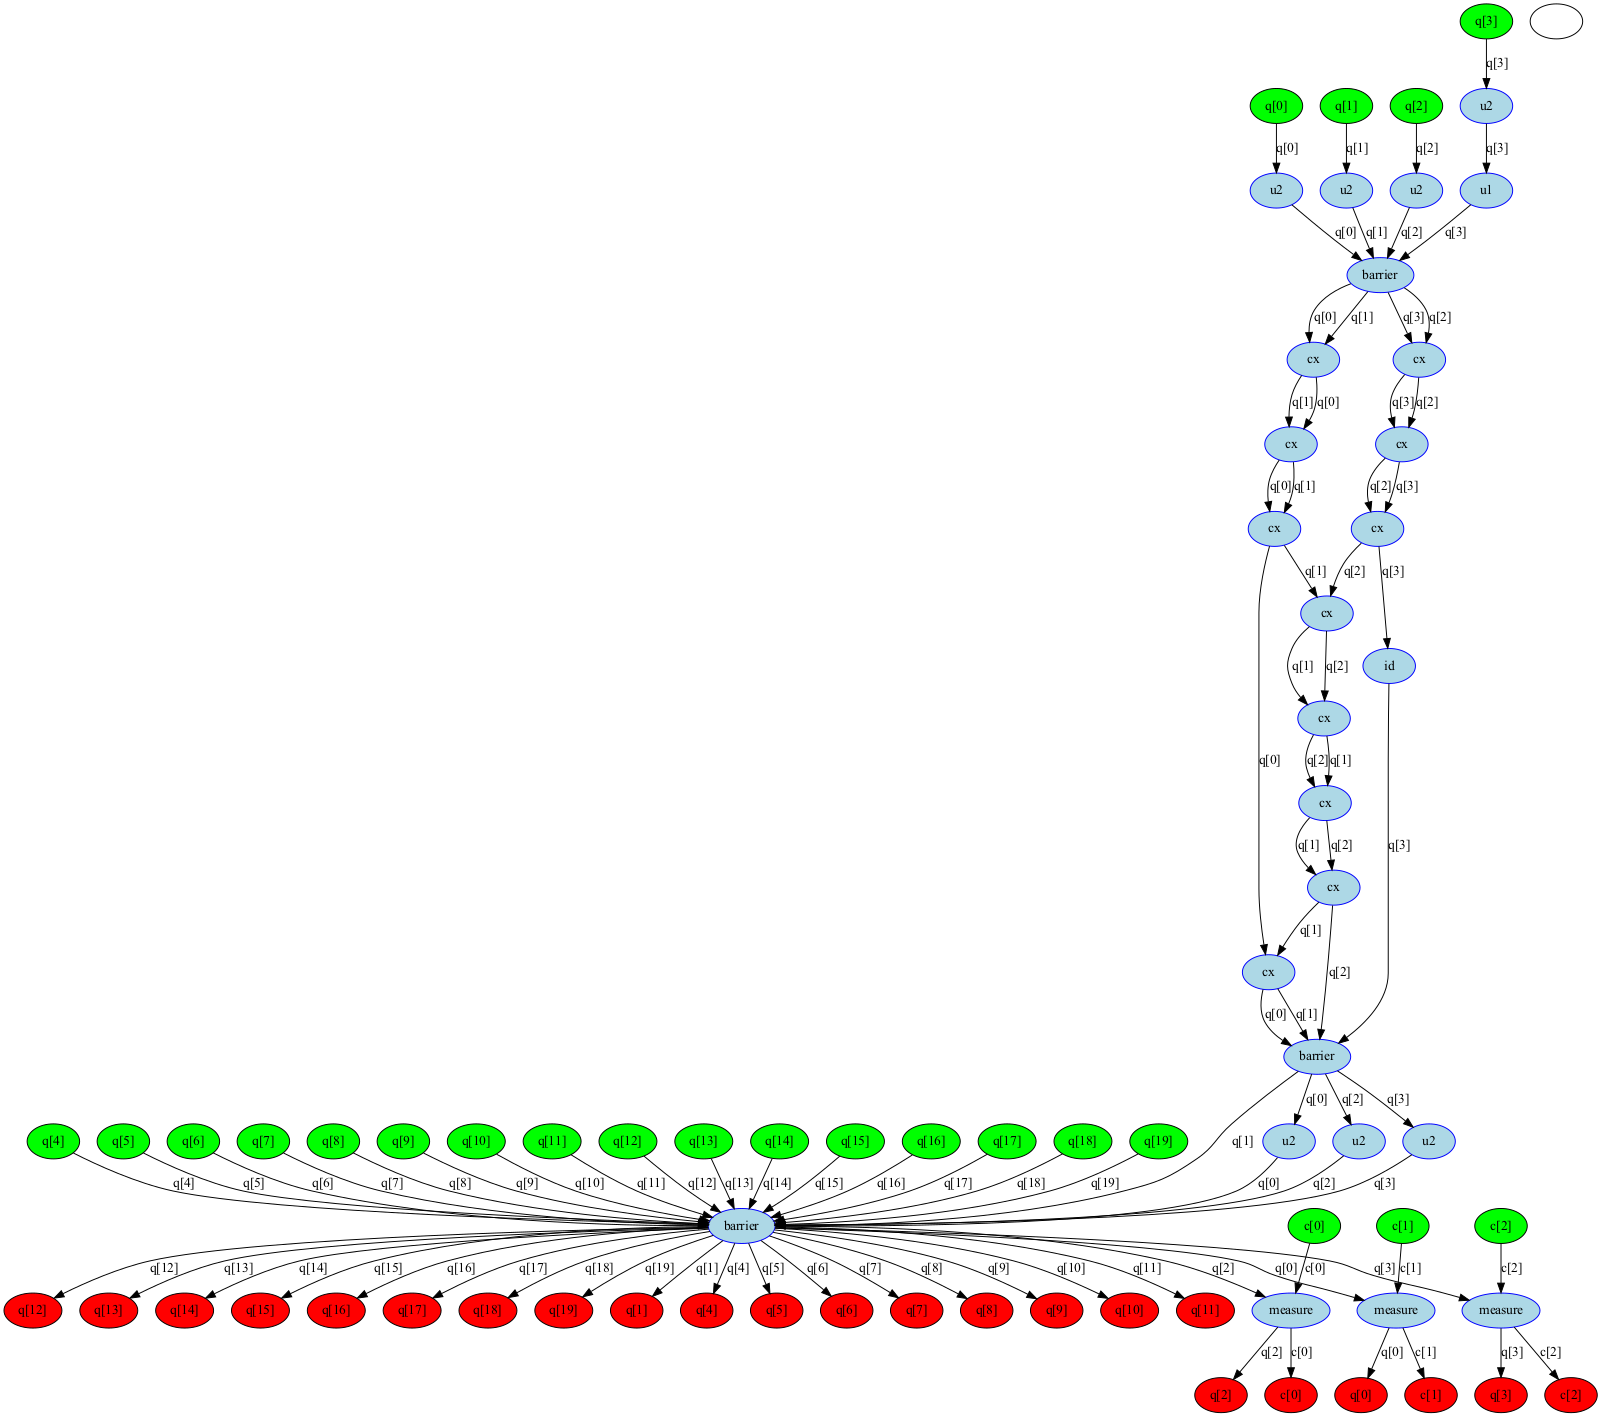

In [63]:
# Draw DAG of the transpiled circuit that used optimization_level=0
dag = circuit_to_dag(transpiled_qc0)
dag_drawer(dag)

As you can see, we have a total of 20 quantum registers because we choice `FakeBoeblingen()` as our backend which has 20 qubits. However, this DAG does not use any quantum registers above q[3]. Feel free to define a different backend and see how the DAG will look like.

### Optimization_level=1


In [64]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc1 = transpile(qc, simulated_backend, optimization_level=1)  # Some Optimization
print('Optimization Level 1')
print('Depth:', transpiled_qc1.depth())
print('Gate counts:', transpiled_qc1.count_ops())
transpiled_qc1.draw()

Optimization Level 1
Depth: 5
Gate counts: OrderedDict([('u2', 7), ('measure', 3), ('barrier', 2), ('cx', 2)])


ancilla_0 -> 0 ─────────────────────────────────────────────────
                                                                  
  ancilla_1 -> 1 ─────────────────────────────────────────────────
                                                                  
  ancilla_2 -> 2 ─────────────────────────────────────────────────
                                                                  
  ancilla_3 -> 3 ─────────────────────────────────────────────────
                                                                  
  ancilla_4 -> 4 ─────────────────────────────────────────────────
                                                                  
  ancilla_5 -> 5 ─────────────────────────────────────────────────
                                                                  
  ancilla_6 -> 6 ─────────────────────────────────────────────────
                 ┌───────────┐ ░ ┌───┐┌───┐ ░                     
        q_3 -> 7 ┤ U2(-π,-π) ├─░─┤ X ├┤ X ├─░─────────────────────
                 └┬─────────┬┘ ░ └─┬─┘└─┬─┘ ░ ┌─────────┐   ┌─┐   
        q_1 -> 8 ─┤ U2(0,π) ├──░───┼────■───░─┤ U2(0,π) ├───┤M├───
                  └─────────┘  ░   │        ░ └─────────┘   └╥┘   
  ancilla_7 -> 9 ──────────────────┼─────────────────────────╫────
                                   │                         ║    
 ancilla_8 -> 10 ──────────────────┼─────────────────────────╫────
                                   │                         ║    
 ancilla_9 -> 11 ──────────────────┼─────────────────────────╫────
                  ┌─────────┐  ░   │        ░ ┌─────────┐┌─┐ ║    
       q_0 -> 12 ─┤ U2(0,π) ├──░───■────────░─┤ U2(0,π) ├┤M├─╫────
                  └─────────┘  ░            ░ └─────────┘└╥┘ ║    
ancilla_10 -> 13 ─────────────────────────────────────────╫──╫────
                                                          ║  ║    
ancilla_11 -> 14 ─────────────────────────────────────────╫──╫────
                  ┌─────────┐  ░            ░ ┌─────────┐ ║  ║ ┌─┐
       q_2 -> 15 ─┤ U2(0,π) ├──░────────────░─┤ U2(0,π) ├─╫──╫─┤M├
                  └─────────┘  ░            ░ └─────────┘ ║  ║ └╥┘
ancilla_12 -> 16 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
ancilla_13 -> 17 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
ancilla_14 -> 18 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
ancilla_15 -> 19 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
            c: 3/═════════════════════════════════════════╩══╩══╩═
                                                          0  1  2

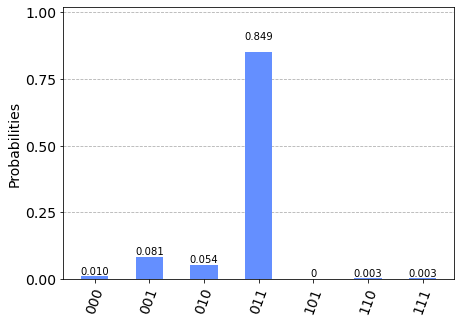

In [65]:
results_BV_Lev1 = simulated_backend.run(transpiled_qc1).result()
counts = results_BV_Lev1.get_counts()
plot_histogram(counts)
# optimization_level=1: maps the circuit, but also does light-weight optimizations by collapsing adjacent gates.

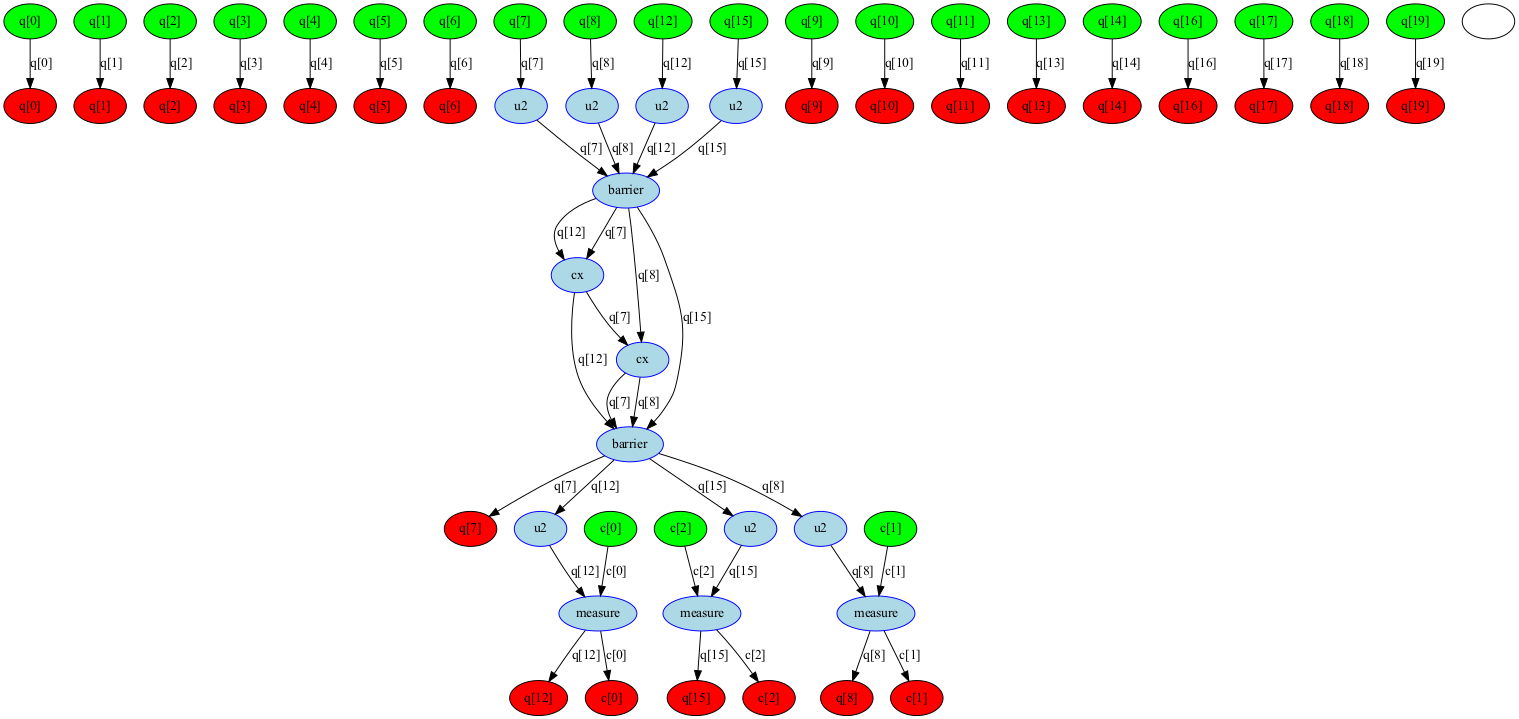

In [66]:
# Draw DAG of the transpiled circuit that used optimization_level=1
dag = circuit_to_dag(transpiled_qc1)
dag_drawer(dag)

### Optimization_level=2


In [67]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc2 = transpile(qc, simulated_backend, optimization_level=2)  # More Optimization
print('Optimization Level 2')
print('Depth:', transpiled_qc2.depth())
print('Gate counts:', transpiled_qc2.count_ops())
transpiled_qc2.draw()

Optimization Level 2
Depth: 5
Gate counts: OrderedDict([('u2', 7), ('measure', 3), ('barrier', 2), ('cx', 2)])


ancilla_0 -> 0 ─────────────────────────────────────────────────
                                                                  
  ancilla_1 -> 1 ─────────────────────────────────────────────────
                                                                  
  ancilla_2 -> 2 ─────────────────────────────────────────────────
                 ┌───────────┐ ░ ┌───┐┌───┐ ░                     
        q_3 -> 3 ┤ U2(-π,-π) ├─░─┤ X ├┤ X ├─░─────────────────────
                 └┬─────────┬┘ ░ └─┬─┘└─┬─┘ ░ ┌─────────┐   ┌─┐   
        q_1 -> 4 ─┤ U2(0,π) ├──░───┼────■───░─┤ U2(0,π) ├───┤M├───
                  └─────────┘  ░   │        ░ └─────────┘   └╥┘   
  ancilla_3 -> 5 ──────────────────┼─────────────────────────╫────
                                   │                         ║    
  ancilla_4 -> 6 ──────────────────┼─────────────────────────╫────
                                   │                         ║    
  ancilla_5 -> 7 ──────────────────┼─────────────────────────╫────
                  ┌─────────┐  ░   │        ░ ┌─────────┐┌─┐ ║    
        q_0 -> 8 ─┤ U2(0,π) ├──░───■────────░─┤ U2(0,π) ├┤M├─╫────
                  └─────────┘  ░            ░ └─────────┘└╥┘ ║    
  ancilla_6 -> 9 ─────────────────────────────────────────╫──╫────
                                                          ║  ║    
 ancilla_7 -> 10 ─────────────────────────────────────────╫──╫────
                                                          ║  ║    
 ancilla_8 -> 11 ─────────────────────────────────────────╫──╫────
                                                          ║  ║    
 ancilla_9 -> 12 ─────────────────────────────────────────╫──╫────
                                                          ║  ║    
ancilla_10 -> 13 ─────────────────────────────────────────╫──╫────
                                                          ║  ║    
ancilla_11 -> 14 ─────────────────────────────────────────╫──╫────
                  ┌─────────┐  ░            ░ ┌─────────┐ ║  ║ ┌─┐
       q_2 -> 15 ─┤ U2(0,π) ├──░────────────░─┤ U2(0,π) ├─╫──╫─┤M├
                  └─────────┘  ░            ░ └─────────┘ ║  ║ └╥┘
ancilla_12 -> 16 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
ancilla_13 -> 17 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
ancilla_14 -> 18 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
ancilla_15 -> 19 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
            c: 3/═════════════════════════════════════════╩══╩══╩═
                                                          0  1  2

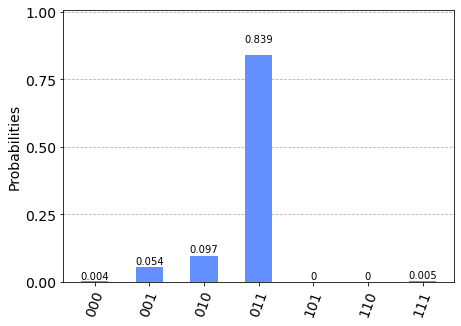

In [68]:
results_BV_Lev2 = simulated_backend.run(transpiled_qc2).result()
counts = results_BV_Lev2.get_counts()
plot_histogram(counts)
# optimization_level=2: medium-weight optimization, including a noise-adaptive layout 
# and a gate-cancellation procedure based on gate commutation relationships.

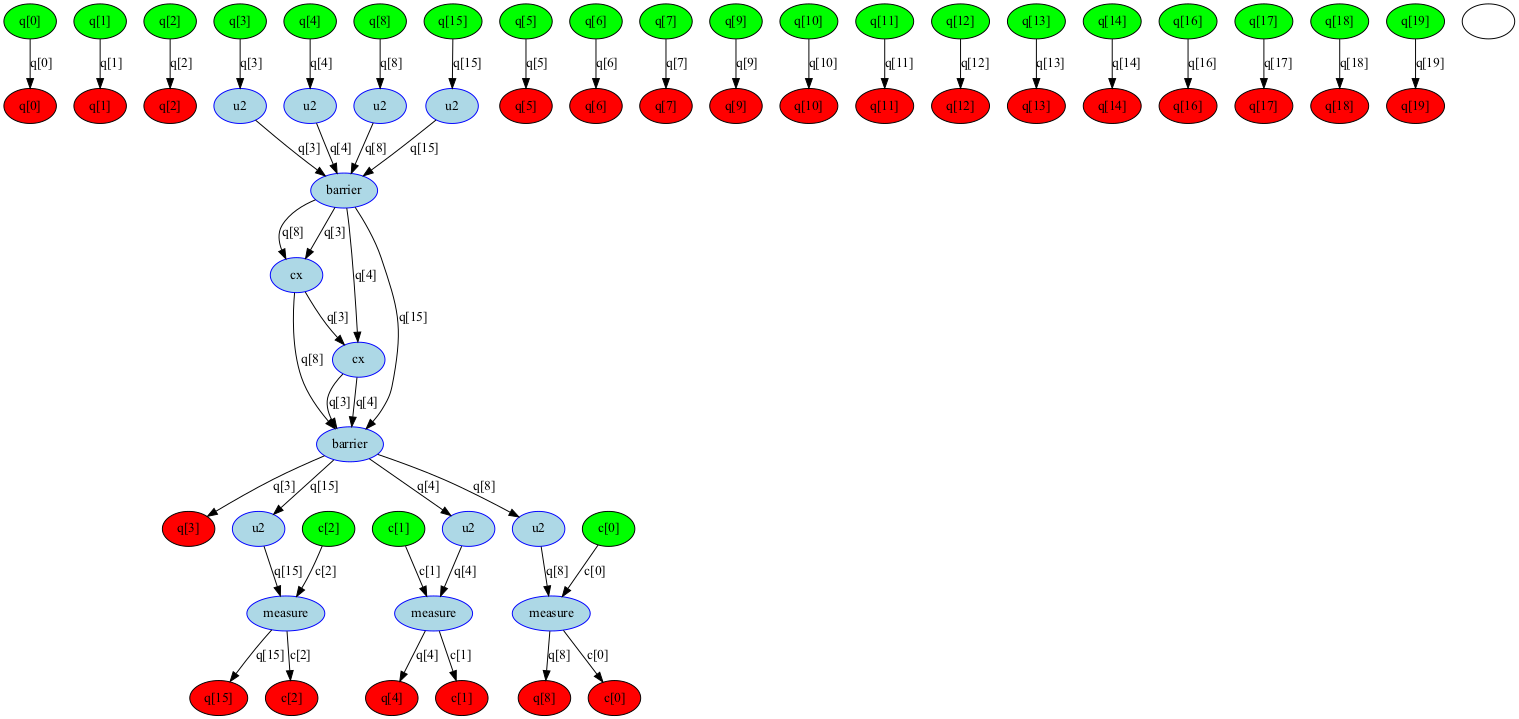

In [69]:
# Draw DAG of the transpiled circuit that used optimization_level=1
dag = circuit_to_dag(transpiled_qc2)
dag_drawer(dag)

### Optimization_level=3


In [70]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc3 = transpile(qc, simulated_backend, optimization_level=3)  # MAXIMUM Optimization!!!
print('Optimization Level 3')
print('Depth:', transpiled_qc3.depth())
print('Gate counts:', transpiled_qc3.count_ops())
transpiled_qc3.draw()

Optimization Level 3
Depth: 5
Gate counts: OrderedDict([('u2', 7), ('measure', 3), ('barrier', 2), ('cx', 2)])


ancilla_0 -> 0 ─────────────────────────────────────────────────
                                                                  
  ancilla_1 -> 1 ─────────────────────────────────────────────────
                                                                  
  ancilla_2 -> 2 ─────────────────────────────────────────────────
                                                                  
  ancilla_3 -> 3 ─────────────────────────────────────────────────
                                                                  
  ancilla_4 -> 4 ─────────────────────────────────────────────────
                                                                  
  ancilla_5 -> 5 ─────────────────────────────────────────────────
                                                                  
  ancilla_6 -> 6 ─────────────────────────────────────────────────
                                                                  
  ancilla_7 -> 7 ─────────────────────────────────────────────────
                                                                  
  ancilla_8 -> 8 ─────────────────────────────────────────────────
                                                                  
  ancilla_9 -> 9 ─────────────────────────────────────────────────
                                                                  
ancilla_10 -> 10 ─────────────────────────────────────────────────
                 ┌───────────┐ ░ ┌───┐┌───┐ ░                     
       q_3 -> 11 ┤ U2(-π,-π) ├─░─┤ X ├┤ X ├─░─────────────────────
                 └┬─────────┬┘ ░ └─┬─┘└─┬─┘ ░ ┌─────────┐┌─┐      
       q_0 -> 12 ─┤ U2(0,π) ├──░───■────┼───░─┤ U2(0,π) ├┤M├──────
                  └─────────┘  ░        │   ░ └─────────┘└╥┘      
ancilla_11 -> 13 ───────────────────────┼─────────────────╫───────
                                        │                 ║       
ancilla_12 -> 14 ───────────────────────┼─────────────────╫───────
                  ┌─────────┐  ░        │   ░ ┌─────────┐ ║    ┌─┐
       q_2 -> 15 ─┤ U2(0,π) ├──░────────┼───░─┤ U2(0,π) ├─╫────┤M├
                  ├─────────┤  ░        │   ░ ├─────────┤ ║ ┌─┐└╥┘
       q_1 -> 16 ─┤ U2(0,π) ├──░────────■───░─┤ U2(0,π) ├─╫─┤M├─╫─
                  └─────────┘  ░            ░ └─────────┘ ║ └╥┘ ║ 
ancilla_13 -> 17 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
ancilla_14 -> 18 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
ancilla_15 -> 19 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
            c: 3/═════════════════════════════════════════╩══╩══╩═
                                                          0  1  2

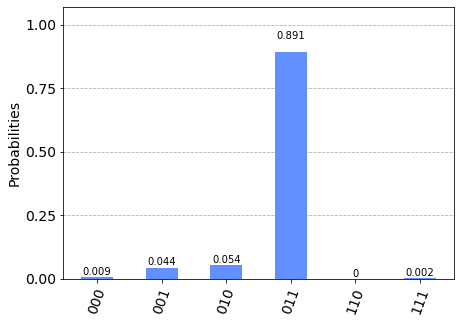

In [71]:
results_BV_Lev3 = simulated_backend.run(transpiled_qc3).result()
counts = results_BV_Lev3.get_counts()
plot_histogram(counts)
# optimization_level=3: heavy-weight optimization, which in addition 
# to previous steps, does resynthesis of two-qubit blocks of gates in the circuit.

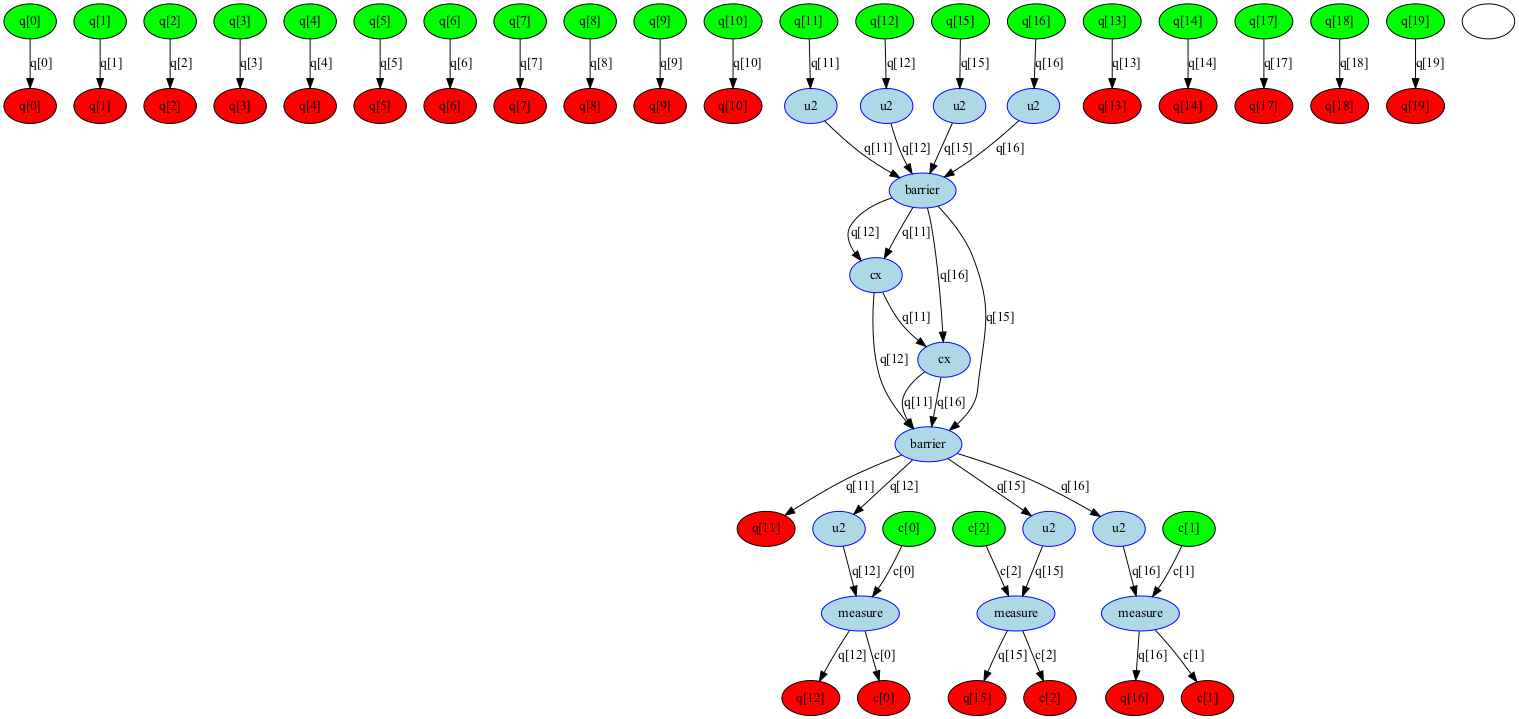

In [72]:
# Draw DAG of the transpiled circuit that used optimization_level=1
dag = circuit_to_dag(transpiled_qc3)
dag_drawer(dag)

As you can see, this DAG of the transpiled circuit is reduced when using higher optimization levels. Furthermore, q[0] through q[3] contains less nodes than previous DAGs which means fewer operations, and a more efficient, less noisy quantum circuit :)

### Converting Qiskit Circuit into a Qasm file.

In [73]:
# Qiskit Circuit  -->  .qasm file
transpiled_qc3.qasm(formatted=True, filename='Bernstein_Vazirani.qasm')
new_qc = QuantumCircuit.from_qasm_file('Bernstein_Vazirani.qasm')

OPENQASM 2.0;
include "qelib1.inc";
qreg q[20];
creg c[3];
u2(-pi,-pi) q[11];
u2(0,pi) q[12];
u2(0,pi) q[15];
u2(0,pi) q[16];
barrier q[12],q[16],q[15],q[11];
cx q[12],q[11];
cx q[16],q[11];
barrier q[12],q[16],q[15],q[11];
u2(0,pi) q[12];
u2(0,pi) q[15];
u2(0,pi) q[16];
measure q[12] -> c[0];
measure q[16] -> c[1];
measure q[15] -> c[2];



# Example 2: Trotterization
### What is Trotterization?
Please look [HERE](https://vtomole.com/blog/2019/04/07/trotter) for a thorough explanation

### Why is Trotterization important?
It is widely used to simulate non-commuting hamiltonians on quantum computers.

### Why did we choose Trotterization example for the quantum compilation process?
Trotterization has already been rigorously analyzed and is not too complicated to show its corresponding quantum circuit. Therefore, it serves as a simple, but important example. Rather than focus on the trotterization algorithm itself (already rigorously analyzed), we will focus on optimizing a trotterization quantum circuit using the Qiskit transpilation process.

### Trotterization Circuit for Hamiltonian, $\mathbf{H} = \mathbf{Z} \otimes \mathbf{Z} \otimes \mathbf{Z} \otimes \mathbf{Z}$


In [74]:
# Import all functions
import numpy as np
import scipy as sp
from qiskit import Aer
from qiskit.opflow import PauliTrotterEvolution, StateFn, PauliExpectation
from qiskit.opflow import CircuitSampler, PauliOp
from qiskit.opflow import I, X, Y, Z, Zero, One, Plus, Minus
from qiskit.circuit import Parameter

In [76]:
hamiltonian = (Z^Z^Z^Z)
evo_time = Parameter('t')
evolution_op = (evo_time*hamiltonian).exp_i()
num_time_slices = 1
trotterized_op = PauliTrotterEvolution(
                    trotter_mode='trotter',
                    reps=num_time_slices).convert(evolution_op)
trot_op_circ = trotterized_op.to_circuit()
trot_op_circ_decomp = trot_op_circ.decompose()
trot_op_circ_decomp.draw()

┌───┐┌───────────┐┌───┐          
q_0: ──────────┤ X ├┤ Rz(2.0*t) ├┤ X ├──────────
          ┌───┐└─┬─┘└───────────┘└─┬─┘┌───┐     
q_1: ─────┤ X ├──■─────────────────■──┤ X ├─────
     ┌───┐└─┬─┘                       └─┬─┘┌───┐
q_2: ┤ X ├──■───────────────────────────■──┤ X ├
     └─┬─┘                                 └─┬─┘
q_3: ──■─────────────────────────────────────■──

### Choose of Backend
Here we will be using the `FakeAthens()` backend and print out its basic information.
For more information of the backend please visit:
1) [Backend_Resource1](https://qiskit.org/documentation/stubs/qiskit.providers.models.BackendConfiguration.html#qiskit.providers.models.BackendConfiguration)

2) [Backend_Resource2](https://qiskit.org/documentation/tutorials/circuits_advanced/08_gathering_system_information.html)

In [77]:
from qiskit.test.mock import FakeAthens

# Define a simulated noisy backend
simulated_backend = FakeAthens()


# Print out basic features of this backend. Note, I am using a function found in Backend_Resource2
config = simulated_backend.configuration()
print("This backend is called {0}, and is on version {1}. \nIt has {2} qubit{3}. \nIt "
      "{4} OpenPulse programs. \nThe basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

This backend is called fake_athens, and is on version 1.3.13. 
It has 5 qubits. 
It supports OpenPulse programs. 
The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset'].


### Optimization_level=0

In [78]:
#Optimization_Level=0
transpiled_qc0 = transpile(trot_op_circ_decomp, simulated_backend, optimization_level=0)  # No Optimization
print('Optimization Level 0')
print('Depth:', transpiled_qc0.depth())
print('Gate counts:', transpiled_qc0.count_ops())
transpiled_qc0.draw()

Optimization Level 0
Depth: 7
Gate counts: OrderedDict([('cx', 6), ('rz', 1)])


MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

In [ ]:
# Draw DAG of the transpiled circuit that used optimization_level=0
dag = circuit_to_dag(transpiled_qc0)
dag_drawer(dag)

### Optimization_level=1

In [ ]:
#Optimization_Level=0
transpiled_qc1 = transpile(trot_op_circ_decomp, simulated_backend, optimization_level=1)  
print('Optimization Level 1')
print('Depth:', transpiled_qc1.depth())
print('Gate counts:', transpiled_qc1.count_ops())
transpiled_qc1.draw()

In [ ]:
# Draw DAG of the transpiled circuit that used optimization_level=1
dag = circuit_to_dag(transpiled_qc1)
dag_drawer(dag)

### Optimization_level=2

In [ ]:
#Optimization_Level=2
transpiled_qc2 = transpile(trot_op_circ_decomp, simulated_backend, optimization_level=2) 
print('Optimization Level 2')
print('Depth:', transpiled_qc2.depth())
print('Gate counts:', transpiled_qc2.count_ops())
transpiled_qc2.draw(')

In [ ]:
# Draw DAG of the transpiled circuit that used optimization_level=1
dag = circuit_to_dag(transpiled_qc2)
dag_drawer(dag)

### Optimization_level=3

In [ ]:
#Optimization_Level=2
transpiled_qc3 = transpile(trot_op_circ_decomp, simulated_backend, optimization_level=3) 
print('Optimization Level 3')
print('Depth:', transpiled_qc3.depth())
print('Gate counts:', transpiled_qc3.count_ops())
transpiled_qc3.draw('mpl')

In [ ]:
# Draw DAG of the transpiled circuit that used optimization_level=1
dag = circuit_to_dag(transpiled_qc3)
dag_drawer(dag)